In [ ]:
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import os
import json
import zipfile
import subprocess
import shutil
import getpass
import math
import numpy
import pandas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
import matplotlib.pyplot as plt
import plotly.express as px
from pytorch_metric_learning import losses, regularizers
from torchsummary import summary

In [ ]:
torch.manual_seed(20)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
dataset_save_dir = './dataset'

In [ ]:
def one_hot_encode(val):
    arr = numpy.zeros((6,), dtype=int)
    arr[val] = 1
    return arr

def get_bucket_id(age):
  age_floor = int(age)
  if age_floor >= 0 and age_floor <= 5: return 0
  elif age_floor >= 6 and age_floor <= 12: return 1
  elif age_floor >= 13 and age_floor <= 19: return 2
  elif age_floor >= 20 and age_floor <= 29: return 3
  elif age_floor >= 30 and age_floor <= 59: return 4
  else: return 5

def get_ground_truth(age):
  return one_hot_encode(get_bucket_id(age))

In [ ]:
def train(dataloader, model, optimizer, loss_function, loss_optimizer):
    torch.cuda.empty_cache()
    size = len(dataloader.dataset)
    model.train()
    loss_tot = 0.0
    num = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Zeroing the gradients
        optimizer.zero_grad()
        loss_optimizer.zero_grad()

        # Get Embeddings
        embeddings = model(X)

        # Calculate Loss
        loss = loss_function(embeddings, y.argmax(1))

        # Backpropagation
        loss.backward()

        # Update
        optimizer.step()
        loss_optimizer.step()

        loss_tot += loss.item()
        num += 1

        X.cpu()
        y.cpu()

    # loss_tot /= num
    print(f'training loss: {(loss_tot):>0.5f}')

In [ ]:
validation_accuracy = []
current_max_val_acc = 0.0
def validation(dataloader, model, loss_function):
    global current_max_val_acc
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    totalsize = 0
    loss_tot = 0.0
    num = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward With Logits
            embeddings = model(X)
            logits = loss_function.get_logits(embeddings)
            predSoftmax = nn.Softmax(dim=1)(logits)
            loss = loss_function(embeddings,y.argmax(1))

            correct += (predSoftmax.argmax(1) == y.argmax(1)).sum().item()
            totalsize += predSoftmax.shape[0]
            loss_tot += loss.item()
            num += 1
            X.cpu()
            y.cpu()

    print(f"Correct/Total: {correct}/{totalsize}")
    correct /= totalsize
    validation_accuracy.append(correct*100)
    print(f"Validation Loss:  {(loss_tot):>0.5f}")
    print(f"Validation Accuracy: {(100*correct):>0.5f}%\n")
    current_max_val_acc = max(current_max_val_acc,100*correct)
    print(f"Current Best Validation Accuracy: {(current_max_val_acc):>0.5f}%\n")
    return loss_tot

In [ ]:
class XRayToothDataset(Dataset):
    def __init__(self, cwd, img_dir, transform=None, target_height=None, target_width=None):
        self.dataset_path = cwd + '/' + img_dir
        self.transform = transform
        self.target_height = target_height
        self.target_width = target_width

    def __len__(self):
        return len(os.listdir(self.dataset_path))

    def __getitem__(self, idx):
        if idx  >= len(os.listdir(self.dataset_path)):
            print("No datafile/image at index : "+ str(idx))
            return None
        img_filename = os.listdir(self.dataset_path)[idx]
        age = float(img_filename.split("_")[1][:-4])
        age_gt = get_ground_truth(age)
        image_tensor = read_image(path=self.dataset_path + '/' + img_filename)
        image_tensor = image_tensor.reshape(1, 3, image_tensor.shape[-2], image_tensor.shape[-1])
        if self.target_height and self.target_width: # Resize the image
            image_tensor = torch.nn.functional.interpolate(image_tensor, (self.target_height,self.target_width))
        if self.transform: image_tensor = self.transform(image_tensor) # Apply transformations
        image_tensor = (image_tensor-image_tensor.min())/(image_tensor.max()-image_tensor.min())
        return image_tensor.reshape(-1,image_tensor.shape[-2],image_tensor.shape[-1]).to(torch.float32), torch.tensor(age_gt)

In [ ]:
# Data Augmentation Transformations
data_augmentation_transformations = T.RandomChoice([
    T.RandomAffine(degrees=0), # No Augmentation
    T.Lambda(lambda x: TF.hflip(img=x)) # Horizontal Flip

    # Geometric Transformations:
    # T.RandomAffine(degrees=0, scale=(1.3,1.3)), # Scale
    # T.RandomAffine(degrees=0, translate=(0.5,0.5)), # Translate
    # T.RandomAffine(degrees=(-8, 8)), # Rotate
    # T.Lambda(lambda x: TF.hflip(img=x)), # Reflect

    # Occlusion:
    # T.Compose([T.RandomErasing(p=1, scale=(0.0008, 0.0008), ratio=(1,1))]*100), # Occlusion

    # Intensity Operations
    # T.Lambda(lambda x: TF.adjust_gamma(img=x, gamma=0.5)), # Gamma Contrast
    # T.Lambda(lambda x: TF.adjust_contrast(x, contrast_factor=2.0)), # Linear Contrast

    # Filtering:
    # T.Lambda(lambda x: TF.adjust_sharpness(img=x, sharpness_factor=4)), #Sharpen
    # T.GaussianBlur(kernel_size=(15,15), sigma=(0.01, 1)), # Gaussian Blur
])

In [ ]:
training_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/training', transform=data_augmentation_transformations, target_height=224, target_width=224)
validation_data = XRayToothDataset(os.getcwd(), img_dir=dataset_save_dir+'/validation', transform=None, target_height=224, target_width=224)

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 84.6MB/s]


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = model

        for param in self.backbone.parameters():
            param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(1000,512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512,256)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
# Test a forward pass
with torch.no_grad():
    print(model(training_data[0][0].reshape(-1,3,224,224).to(device)))

tensor([[-0.0221, -0.0462,  0.1013,  0.1963,  0.0701,  0.4553, -0.3117, -0.2951,
          0.0362, -0.2434,  0.4259, -0.3953,  0.2456, -0.2566, -0.2399, -0.2747,
          0.0081, -0.3271, -0.0814,  0.0490, -0.0453, -0.1244,  0.5989,  0.0416,
          0.2166, -0.0084, -0.6607,  0.1490,  0.0561,  0.3155,  0.3872,  0.1031,
         -0.3405,  0.2377,  0.7468,  0.2450,  0.4333, -0.8494,  0.3430,  0.0061,
          0.0178, -0.1785,  0.3770, -0.4505,  0.8188,  0.2506,  0.5856, -0.2743,
         -0.4057,  0.3537,  0.4051,  0.1675, -0.3817,  0.0922, -0.3892, -0.0720,
          0.2080, -0.1915,  0.1065, -0.1449, -0.0683, -0.3152,  0.6982,  0.0050,
         -0.6477,  0.1380,  0.2857,  0.0839, -0.3680, -0.0742,  0.3654, -0.1051,
         -0.4081,  0.4877,  0.1813, -0.4003, -0.2797,  0.0502, -0.1043,  0.1353,
          0.1555,  0.2753, -0.4192, -0.3296, -0.2096, -0.1209, -0.3120,  0.3074,
          0.6080, -0.0345,  0.1286, -0.0231,  0.2780, -0.0888,  0.2309, -0.1096,
          0.5269, -0.1190, -

In [ ]:
# Training Hyperparameters
epochs = 500
batch_size = 10
learning_rate = 1e-2
momentum=0.9
weight_decay=0.05

# Margin Loss Hyperparameters
margin_loss_learning_rate = 9e-1

In [ ]:
training_data_loader = DataLoader(training_data, batch_size, shuffle = True)
validation_data_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [ ]:
# Loss
margin_loss_regularizer = regularizers.RegularFaceRegularizer()
margin_loss_function = losses.ArcFaceLoss(6, 256, margin=34.3, scale=1, weight_regularizer=margin_loss_regularizer).to(device)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_optimizer = torch.optim.SGD(margin_loss_function.parameters(), lr=margin_loss_learning_rate)

# Schedulers
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=5, min_lr=1e-5,verbose=True)
margin_loss_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=5, min_lr=1e-5,verbose=True)

In [ ]:
# Training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data_loader, model, optimizer, margin_loss_function, loss_optimizer)
    val_loss = validation(validation_data_loader, model, margin_loss_function)
    scheduler.step(val_loss)
    margin_loss_scheduler.step(val_loss)
print("Done!")

Epoch 1
-------------------------------
training loss: 56.38902
Correct/Total: 67/129
Validation Loss:  23.65873
Validation Accuracy: 51.93798%

Current Best Validation Accuracy: 51.93798%

Epoch 2
-------------------------------
training loss: 53.02827
Correct/Total: 67/129
Validation Loss:  22.85099
Validation Accuracy: 51.93798%

Current Best Validation Accuracy: 51.93798%

Epoch 3
-------------------------------
training loss: 51.70736
Correct/Total: 69/129
Validation Loss:  22.21119
Validation Accuracy: 53.48837%

Current Best Validation Accuracy: 53.48837%

Epoch 4
-------------------------------
training loss: 49.26062
Correct/Total: 69/129
Validation Loss:  21.84559
Validation Accuracy: 53.48837%

Current Best Validation Accuracy: 53.48837%

Epoch 5
-------------------------------
training loss: 48.02312
Correct/Total: 75/129
Validation Loss:  21.17650
Validation Accuracy: 58.13953%

Current Best Validation Accuracy: 58.13953%

Epoch 6
-------------------------------
training l

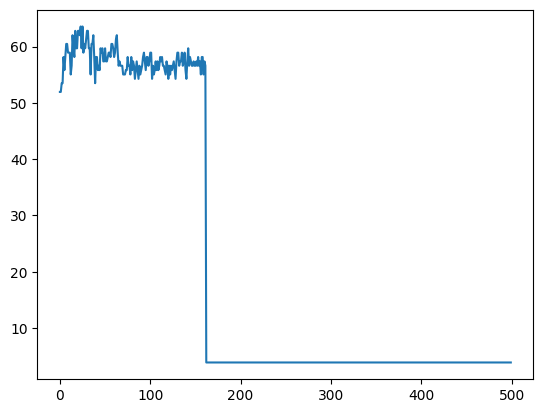

In [ ]:
plt.plot(validation_accuracy)